In [15]:
# !pip install -r requirements.txt

# Data Setup

In [2]:
#imports
from src.simulated_annealing import generate_fig, run_annealer
from src.annealer import Annealer

from kloppy import skillcorner
from databallpy import get_game_from_kloppy
from databallpy.visualize import plot_soccer_pitch, plot_tracking_data
from databallpy.features.pitch_control import get_pitch_control_single_frame

import pandas as pd
import accessible_space
import pickle

In [3]:
match_id = 1886347
tracking_data_github_url = f"https://media.githubusercontent.com/media/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl"
meta_data_github_url = f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_match.json"

dataset = skillcorner.load(
    meta_data=meta_data_github_url,
    raw_data=tracking_data_github_url,
    # Optional Parameters
    coordinates="skillcorner",
    limit=500, 
)


#actual script
game = get_game_from_kloppy(dataset)
game.tracking_data.add_velocity(game.get_column_ids() + ["ball"], allow_overwrite=True)
game.tracking_data.add_individual_player_possession()
selected_frame_idx = 210

/Users/amar/Documents/python_notebooks/dev_312/lib/python3.12/site-packages/databallpy/utils/get_game.py:865: UserWarning: All frames in 'tracking_dataset' are 'ALIVE', databallpy expects 'DEAD' frames as well (e.g. for more accurate event synchronization). Set `only_alive=False` in your kloppy `.load_tracking()` call to include 'DEAD' frames.
  warnings.warn(


# Situation to optimise

Here's the first situation we'll look at. In this case, we've visualised the pitch control of the teams using the standard pitch control model available in databallpy.

(<Figure size 1200x800 with 1 Axes>, <Axes: >)

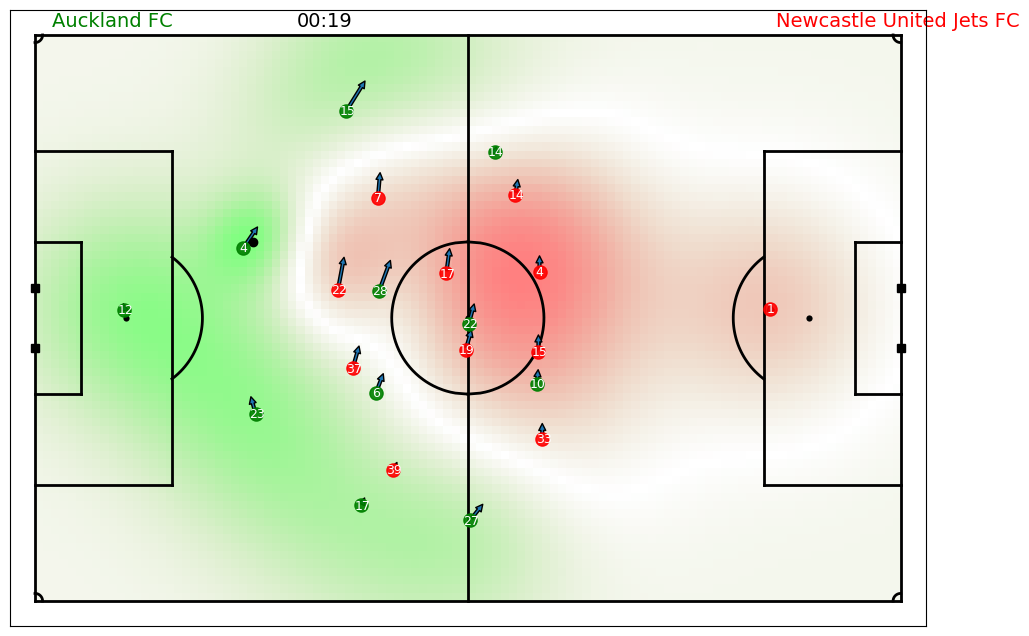

In [4]:
generate_fig(game, selected_frame_idx)

### Computing a Score for this situation

From this, we could compute various metrics about the red (defensive) team to quantify how good this position is. For example, we can compute the total pitch control of this position 

In [5]:
pc = get_pitch_control_single_frame(game.tracking_data[game.tracking_data['frame']==selected_frame_idx].iloc[0],
            game.pitch_dimensions,
            n_x_bins=106, n_y_bins=68,
        )
print(f"total pitch control: {sum(sum(pc))}")

total pitch control: 3690.9865385590947


### Maximising Weighted Pitch Control

* Now let's think about how we can improve this position. We could try to see how we can move the players to maximise pitch control.
* However, this would treat each square on the pitch as if it had the same value, so we'll use an xT weighted pitch control.
* In this case, our xT comes directly from a static model of Premier League xT from https://karun.in/blog/expected-threat.html , but we could, with more time, come up with something more complex that takes into account the specifics of this league

In [6]:
# Multiply each pitch control value by the associated threat in that position
with open("src/xTArray.pkl", "rb") as f:
    xt_array = pickle.load(f) #this assumes team is attacking from L to R, need to use np.fliplr if not
print(f"total weighted pitch control before optimisation: {sum(sum(xt_array*pc))}")

total weighted pitch control before optimisation: 127.52464911143325


In [14]:
# Now we need to optimise using our the Simulated Annealer
# NOTE: Simulated annealing is inherently random and therefore we may need to re-run this block multiple times until it finds a solution
annealer = Annealer(
            game, 
            selected_frame_idx, 
            distance_perturbation=0.2, # how many yards to randomly move the player on each iteration 
            max_distance_perturbation= 3, # the maximum distance we can move a player in any direction, x or y
            num_iterations=1000, # the number of perturbations to do
            weighted_pitch_control_parameter = 1 
        )
new_game, best_score = run_annealer(annealer, game)

running annealer
iteration 100 / 1000 best_score 194.2415128211524
iteration 200 / 1000 best_score 195.67784125378944
iteration 300 / 1000 best_score 196.6449250016141
iteration 400 / 1000 best_score 197.5350884900539
iteration 500 / 1000 best_score 198.6654768266837
iteration 600 / 1000 best_score 199.25417863510484
iteration 700 / 1000 best_score 200.05394718296816
iteration 800 / 1000 best_score 200.35898752602796
iteration 900 / 1000 best_score 200.56170349798697
best score 200.729366302351


total weighted pitch control after optimisation: 200.729366302351


(<Figure size 1200x800 with 1 Axes>, <Axes: >)

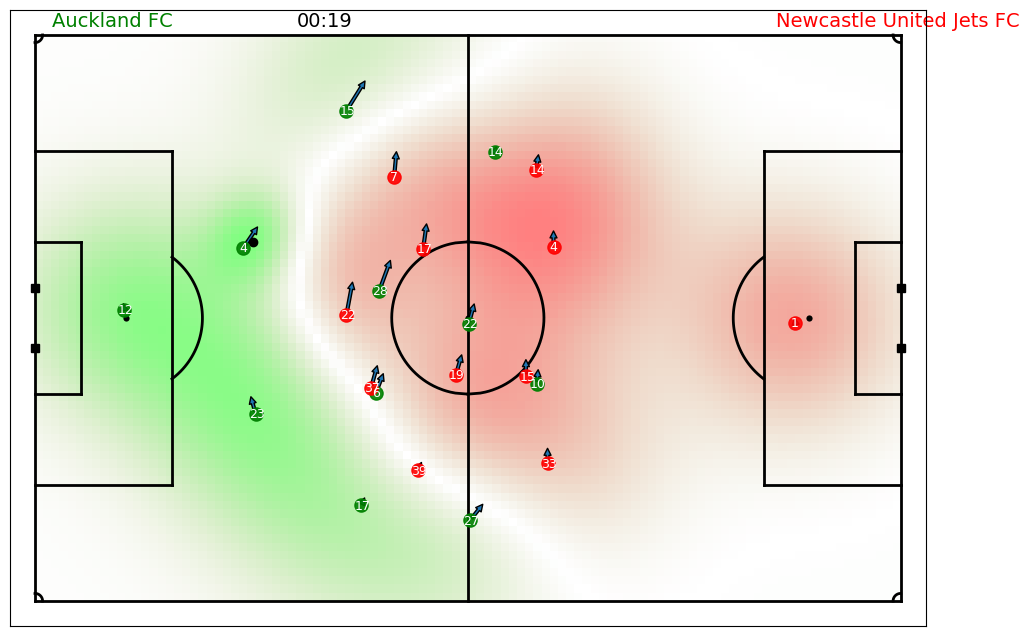

In [15]:
print(f"total weighted pitch control after optimisation: {(best_score)}")
generate_fig(new_game, selected_frame_idx)

* Great, we've now moved the players and can clearly see that the optimiser was able to move the players to positions that maximise the objective function, in this case, xT Weighted Pitch Control.
* This has been achieved by spreading out the players more to cover the width, which was previously mainly occupied by the green team.
* The key problem here is that by only looking at Pitch Control, we've created a few holes in the defence, such as in the center circle around Green Player 22.
* Let's look at 


In [25]:
def plot_das_for_game(game_to_plot):
    df_long = game_to_plot.tracking_data[game_to_plot.tracking_data['frame']==selected_frame_idx].to_long_format()
    
    df_long["team"] = df_long["column_id"].str[:4]
    
    res = accessible_space.get_dangerous_accessible_space(
        df_long,
        frame_col="frame",
        period_col="period_id",
        player_col="column_id",
        team_col="team",
        x_col="x",
        y_col="y",
        vx_col="vx",
        vy_col="vy",
        team_in_possession_col="team_possession",
        player_in_possession_col="player_possession",
    )
    
    fig, ax = plot_soccer_pitch(pitch_color="white")
    fig, ax = plot_tracking_data(
        game_to_plot,
        game_to_plot.tracking_data[game_to_plot.tracking_data["frame"] == selected_frame_idx].index[0],
        fig=fig,
        ax=ax,
        title=f"Accessible space (blue, {res.acc_space.iloc[0]:.0f}m²)",
        add_velocities=True,
    )
    
    fig = accessible_space.plot_expected_completion_surface(
        res.simulation_result,  # AS
        frame_index=0,
        color="blue",
    )
    return fig

Simulating passes: 100%|███████████████████████| 1/1 [00:00<00:00,  3.46chunk/s]


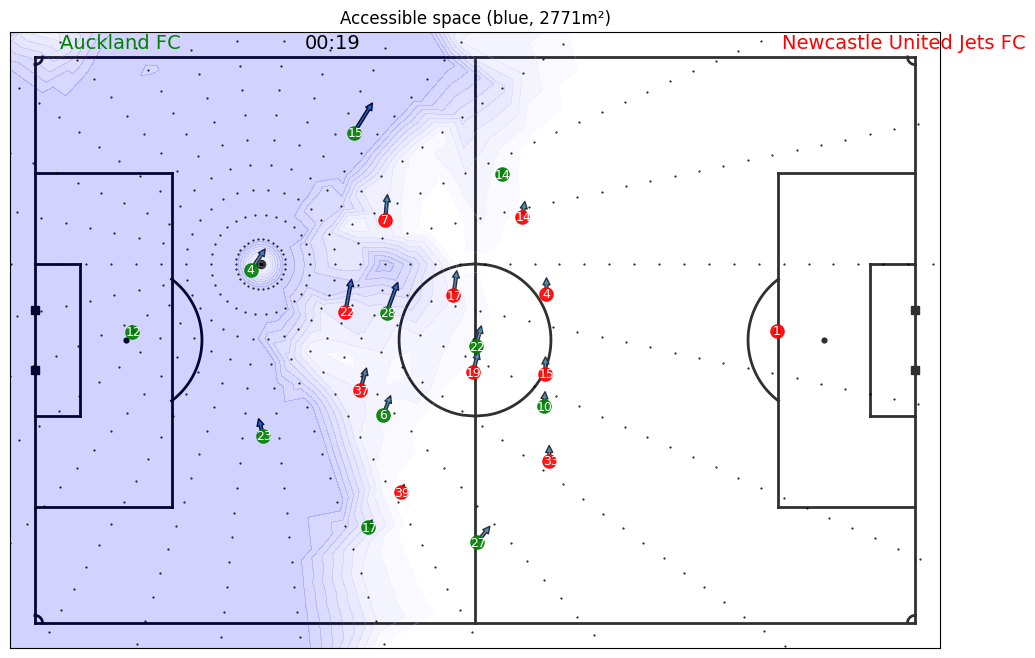

In [26]:
das_before = plot_das_for_game(game)

Simulating passes: 100%|███████████████████████| 1/1 [00:00<00:00,  3.69chunk/s]


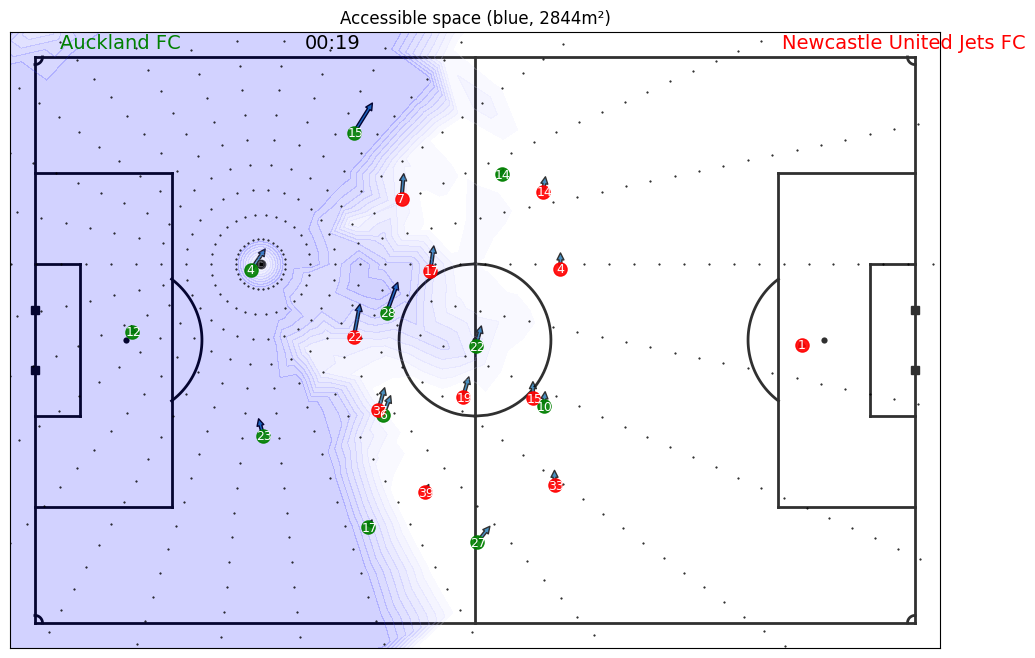

In [27]:
das_after = plot_das_for_game(new_game)

* Looking at Directly Accessible Space before and after optimising for Weighted Pitch Control clearly shows that by optimising for this metric alone.